# Figure 8

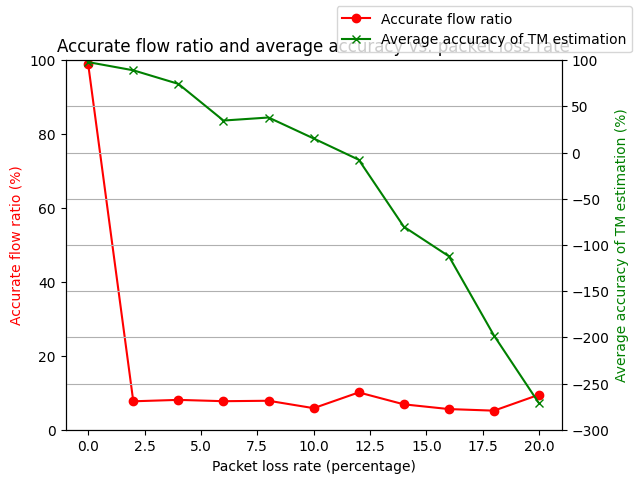

,Packet Loss Rate,Accurate Flow Ratio,Average Accuracy
0,0.00,0.988701,0.978389
1,0.02,0.076923,0.889896
2,0.04,0.080745,0.742860
3,0.06,0.077177,0.346119
4,0.08,0.078370,0.378902
5,0.10,0.058319,0.152117
6,0.12,0.100953,-0.078282
7,0.14,0.068686,-0.802869
8,0.16,0.055872,-1.123061
9,0.18,0.051573,-1.981126


In [1]:

import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import time


def calculate_accurate_flow_ratio_and_average_accuracy(flow_stats_file, trafgen_stats_file):
    # Load the JSON data
    with open(flow_stats_file, 'r') as f:
        flow_stats = json.load(f)

    with open(trafgen_stats_file, 'r') as f:
        trafgen_stats = json.load(f)

    # Initialize counters
    accurate_flow_count = 0
    total_flows = 0
    error_rate_total = 0

    # Calculate accurate flow ratio and average accuracy
    for flow_id, flow_stat in flow_stats.items():
        if flow_id == "1000000000":
            continue
        if flow_id in trafgen_stats:
            trafgen_stat = trafgen_stats[flow_id]
            if trafgen_stat == 0:
                continue
            if flow_stat == trafgen_stat:
                accurate_flow_count += 1
            error_rate = abs(flow_stat - trafgen_stat) / trafgen_stat
            error_rate_total += error_rate
        total_flows += 1

    accurate_flow_ratio = accurate_flow_count / total_flows if total_flows > 0 else 0
    average_error = error_rate_total / total_flows if total_flows > 0 else 0
    average_accuracy = 1 - average_error

    return accurate_flow_ratio, average_accuracy


# Define the packet loss ratios and corresponding files
packet_loss_ratios = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]
flow_stats_files = [f'stats/flow_stats_{ratio}.json' for ratio in packet_loss_ratios]
trafgen_stats_files = [f'stats/trafgen_stats_{ratio}.json' for ratio in packet_loss_ratios]

# Initialize results list
results = []

# Calculate metrics for each packet loss ratio
for ratio, flow_file, trafgen_file in zip(packet_loss_ratios, flow_stats_files, trafgen_stats_files):
    accurate_flow_ratio, average_accuracy = calculate_accurate_flow_ratio_and_average_accuracy(flow_file, trafgen_file)
    results.append([ratio, accurate_flow_ratio, average_accuracy])

# Save results to a CSV file
results_df = pd.DataFrame(results, columns=['Packet Loss Rate', 'Accurate Flow Ratio', 'Average Accuracy'])
# Save results to CSV
timestamp = time.strftime("%Y%m%d-%H%M%S")
filename = f"data/accuracy_results_{timestamp}.csv"
#results_df.to_csv(filename, index=False)

# Plot the results
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(results_df['Packet Loss Rate'] * 100, results_df['Accurate Flow Ratio'] * 100, 'r-', marker='o')
ax2.plot(results_df['Packet Loss Rate'] * 100, results_df['Average Accuracy'] * 100, 'g-', marker='x')

ax1.set_xlabel('Packet loss rate (percentage)')
ax1.set_ylabel('Accurate flow ratio (%)', color='r')
ax2.set_ylabel('Average accuracy of TM estimation (%)', color='g')

plt.title('Accurate flow ratio and average accuracy vs. packet loss rate')
ax1.set_ylim(0, 100)
ax2.set_ylim(-300, 100)

fig.legend(['Accurate flow ratio', 'Average accuracy of TM estimation'], loc='upper right')
plt.grid(True)
plt.show()

# Display the dataframe
results_df

# 0.01

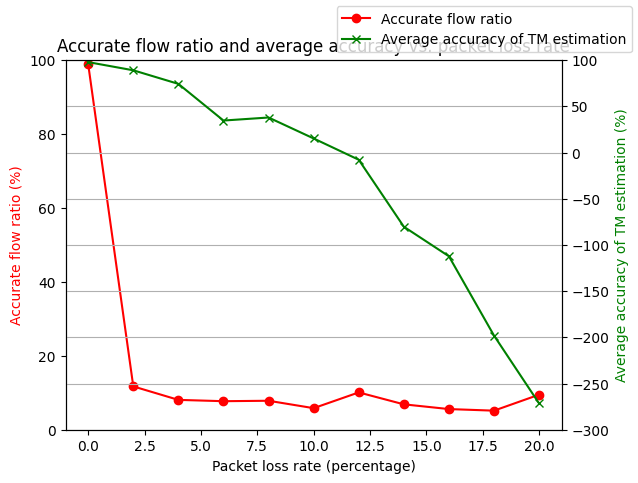

,Packet Loss Rate,Accurate Flow Ratio,Average Accuracy
0,0.00,0.988701,0.978389
1,0.02,0.117188,0.889896
2,0.04,0.080745,0.742860
3,0.06,0.077177,0.346119
4,0.08,0.078370,0.378902
5,0.10,0.058319,0.152117
6,0.12,0.100953,-0.078282
7,0.14,0.068686,-0.802869
8,0.16,0.055872,-1.123061
9,0.18,0.051573,-1.981126


In [2]:

import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import time


def calculate_accurate_flow_ratio_and_average_accuracy(flow_stats_file, trafgen_stats_file):
    # Load the JSON data
    with open(flow_stats_file, 'r') as f:
        flow_stats = json.load(f)

    with open(trafgen_stats_file, 'r') as f:
        trafgen_stats = json.load(f)

    # Initialize counters
    accurate_flow_count = 0
    total_flows = 0
    error_rate_total = 0

    # Calculate accurate flow ratio and average accuracy
    for flow_id, flow_stat in flow_stats.items():
        if flow_id == "1000000000":
            continue
        if flow_id in trafgen_stats:
            trafgen_stat = trafgen_stats[flow_id]
            if trafgen_stat == 0:
                continue
            error_rate = abs(flow_stat - trafgen_stat) / trafgen_stat
            if flow_stat == trafgen_stat or error_rate < 0.01:
                accurate_flow_count += 1
        
            error_rate_total += error_rate
        total_flows += 1

    accurate_flow_ratio = accurate_flow_count / total_flows if total_flows > 0 else 0
    average_error = error_rate_total / total_flows if total_flows > 0 else 0
    average_accuracy = 1 - average_error

    return accurate_flow_ratio, average_accuracy


# Define the packet loss ratios and corresponding files
packet_loss_ratios = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]
flow_stats_files = [f'stats/flow_stats_{ratio}.json' for ratio in packet_loss_ratios]
trafgen_stats_files = [f'stats/trafgen_stats_{ratio}.json' for ratio in packet_loss_ratios]

# Initialize results list
results = []

# Calculate metrics for each packet loss ratio
for ratio, flow_file, trafgen_file in zip(packet_loss_ratios, flow_stats_files, trafgen_stats_files):
    accurate_flow_ratio, average_accuracy = calculate_accurate_flow_ratio_and_average_accuracy(flow_file, trafgen_file)
    results.append([ratio, accurate_flow_ratio, average_accuracy])

# Save results to a CSV file
results_df = pd.DataFrame(results, columns=['Packet Loss Rate', 'Accurate Flow Ratio', 'Average Accuracy'])
# Save results to CSV
timestamp = time.strftime("%Y%m%d-%H%M%S")
filename = f"data/accuracy_results_{timestamp}.csv"
#results_df.to_csv(filename, index=False)

# Plot the results
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(results_df['Packet Loss Rate'] * 100, results_df['Accurate Flow Ratio'] * 100, 'r-', marker='o')
ax2.plot(results_df['Packet Loss Rate'] * 100, results_df['Average Accuracy'] * 100, 'g-', marker='x')

ax1.set_xlabel('Packet loss rate (percentage)')
ax1.set_ylabel('Accurate flow ratio (%)', color='r')
ax2.set_ylabel('Average accuracy of TM estimation (%)', color='g')

plt.title('Accurate flow ratio and average accuracy vs. packet loss rate')
ax1.set_ylim(0, 100)
ax2.set_ylim(-300, 100)

fig.legend(['Accurate flow ratio', 'Average accuracy of TM estimation'], loc='upper right')
plt.grid(True)
plt.show()

# Display the dataframe
results_df

# 0.05

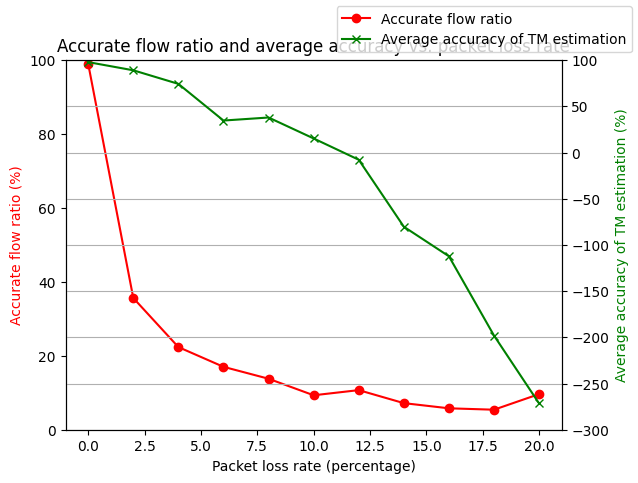

,Packet Loss Rate,Accurate Flow Ratio,Average Accuracy
0,0.00,0.989956,0.978389
1,0.02,0.356370,0.889896
2,0.04,0.223602,0.742860
3,0.06,0.170185,0.346119
4,0.08,0.137931,0.378902
5,0.10,0.093196,0.152117
6,0.12,0.107123,-0.078282
7,0.14,0.071931,-0.802869
8,0.16,0.057941,-1.123061
9,0.18,0.054152,-1.981126


In [3]:

import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import time


def calculate_accurate_flow_ratio_and_average_accuracy(flow_stats_file, trafgen_stats_file):
    # Load the JSON data
    with open(flow_stats_file, 'r') as f:
        flow_stats = json.load(f)

    with open(trafgen_stats_file, 'r') as f:
        trafgen_stats = json.load(f)

    # Initialize counters
    accurate_flow_count = 0
    total_flows = 0
    error_rate_total = 0

    # Calculate accurate flow ratio and average accuracy
    for flow_id, flow_stat in flow_stats.items():
        if flow_id == "1000000000":
            continue
        if flow_id in trafgen_stats:
            trafgen_stat = trafgen_stats[flow_id]
            if trafgen_stat == 0:
                continue
            error_rate = abs(flow_stat - trafgen_stat) / trafgen_stat
            if flow_stat == trafgen_stat or error_rate < 0.05:
                accurate_flow_count += 1
        
            error_rate_total += error_rate
        total_flows += 1

    accurate_flow_ratio = accurate_flow_count / total_flows if total_flows > 0 else 0
    average_error = error_rate_total / total_flows if total_flows > 0 else 0
    average_accuracy = 1 - average_error

    return accurate_flow_ratio, average_accuracy


# Define the packet loss ratios and corresponding files
packet_loss_ratios = [0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]
flow_stats_files = [f'stats/flow_stats_{ratio}.json' for ratio in packet_loss_ratios]
trafgen_stats_files = [f'stats/trafgen_stats_{ratio}.json' for ratio in packet_loss_ratios]

# Initialize results list
results = []

# Calculate metrics for each packet loss ratio
for ratio, flow_file, trafgen_file in zip(packet_loss_ratios, flow_stats_files, trafgen_stats_files):
    accurate_flow_ratio, average_accuracy = calculate_accurate_flow_ratio_and_average_accuracy(flow_file, trafgen_file)
    results.append([ratio, accurate_flow_ratio, average_accuracy])

# Save results to a CSV file
results_df = pd.DataFrame(results, columns=['Packet Loss Rate', 'Accurate Flow Ratio', 'Average Accuracy'])
# Save results to CSV
timestamp = time.strftime("%Y%m%d-%H%M%S")
filename = f"data/accuracy_results_{timestamp}.csv"
#results_df.to_csv(filename, index=False)

# Plot the results
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(results_df['Packet Loss Rate'] * 100, results_df['Accurate Flow Ratio'] * 100, 'r-', marker='o')
ax2.plot(results_df['Packet Loss Rate'] * 100, results_df['Average Accuracy'] * 100, 'g-', marker='x')

ax1.set_xlabel('Packet loss rate (percentage)')
ax1.set_ylabel('Accurate flow ratio (%)', color='r')
ax2.set_ylabel('Average accuracy of TM estimation (%)', color='g')

plt.title('Accurate flow ratio and average accuracy vs. packet loss rate')
ax1.set_ylim(0, 100)
ax2.set_ylim(-300, 100)

fig.legend(['Accurate flow ratio', 'Average accuracy of TM estimation'], loc='upper right')
plt.grid(True)
plt.show()

# Display the dataframe
results_df